In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
import time

# --- 1. Load Data and Embeddings ---

# Load the embeddings we generated previously
try:
    all_embeddings = np.load('all_embeddings.npy')
    df = pd.read_parquet('processed_customer_support_data.parquet')
    print("Pre-computed embeddings and data loaded successfully.")
    print(f"Shape of the embedding matrix: {all_embeddings.shape}")
except FileNotFoundError:
    print("Error: 'all_embeddings.npy' not found. Please run the Duplicate Detection notebook first to generate it.")
    exit()

Pre-computed embeddings and data loaded successfully.
Shape of the embedding matrix: (8469, 768)


In [2]:
# --- 2. Set up the Experiment ---

# Define the range of cluster numbers to test
K_range = range(10, 151, 10)

# Dictionaries to store the results
results = {
    'k': [],
    'kmeans_silhouette': [],
    'kmeans_davies_bouldin': [],
    'kmeans_adj_rand': [],
    'agglo_silhouette': [],
    'agglo_davies_bouldin': [],
    'agglo_adj_rand': [],
}

In [3]:
# --- 3. Run the Comparative Loop ---
print("Starting comparative analysis of K-Means and Agglomerative Clustering.")
print(f"Testing K values from 10 to 150. This will take a long time.\n")

for k in K_range:
    start_time = time.time()
    print(f"--- Processing K={k} ---")
    results['k'].append(k)
    
    # --- K-Means ---
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(all_embeddings)
    results['kmeans_silhouette'].append(silhouette_score(all_embeddings, kmeans_labels))
    results['kmeans_davies_bouldin'].append(davies_bouldin_score(all_embeddings, kmeans_labels))
    results['kmeans_adj_rand'].append(adjusted_rand_score(df['Category'], kmeans_labels))
    
    # --- Agglomerative Clustering ---
    # Using 'ward' linkage is a good default as it minimizes variance within clusters
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agglo_labels = agglo.fit_predict(all_embeddings)
    results['agglo_silhouette'].append(silhouette_score(all_embeddings, agglo_labels))
    results['agglo_davies_bouldin'].append(davies_bouldin_score(all_embeddings, agglo_labels))
    results['agglo_adj_rand'].append(adjusted_rand_score(df['Category'], agglo_labels))
    
    end_time = time.time()
    print(f"Completed K={k} in {end_time - start_time:.2f} seconds.")

# Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results)
print("\n--- Comparative Analysis Complete ---")
print(results_df)

Starting comparative analysis of K-Means and Agglomerative Clustering.
Testing K values from 10 to 150. This will take a long time.

--- Processing K=10 ---
Completed K=10 in 8.21 seconds.
--- Processing K=20 ---
Completed K=20 in 8.18 seconds.
--- Processing K=30 ---
Completed K=30 in 8.06 seconds.
--- Processing K=40 ---
Completed K=40 in 8.32 seconds.
--- Processing K=50 ---
Completed K=50 in 8.66 seconds.
--- Processing K=60 ---
Completed K=60 in 8.97 seconds.
--- Processing K=70 ---
Completed K=70 in 8.54 seconds.
--- Processing K=80 ---
Completed K=80 in 8.87 seconds.
--- Processing K=90 ---
Completed K=90 in 8.82 seconds.
--- Processing K=100 ---
Completed K=100 in 9.27 seconds.
--- Processing K=110 ---
Completed K=110 in 9.34 seconds.
--- Processing K=120 ---
Completed K=120 in 9.80 seconds.
--- Processing K=130 ---
Completed K=130 in 9.25 seconds.
--- Processing K=140 ---
Completed K=140 in 9.32 seconds.
--- Processing K=150 ---
Completed K=150 in 9.38 seconds.

--- Comparativ

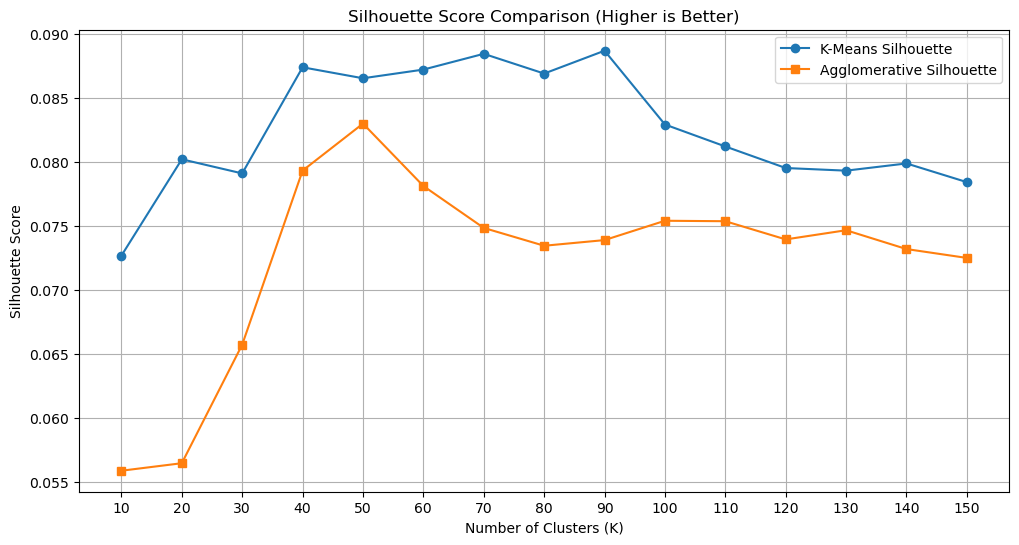

In [4]:
# --- 4. Visualize the Results ---

# Plot Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(results_df['k'], results_df['kmeans_silhouette'], 'o-', label='K-Means Silhouette')
plt.plot(results_df['k'], results_df['agglo_silhouette'], 's-', label='Agglomerative Silhouette')
plt.title('Silhouette Score Comparison (Higher is Better)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.show()

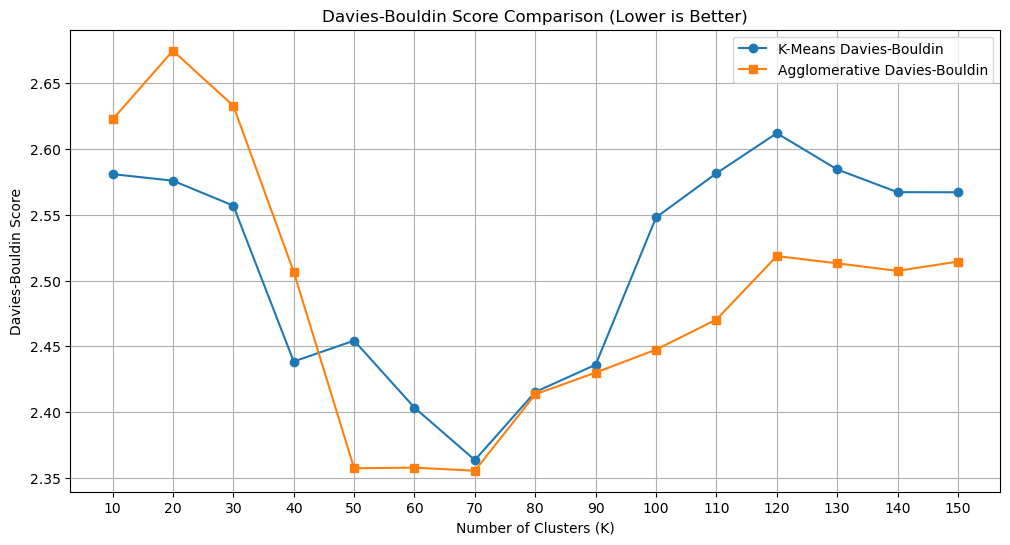

In [5]:
# Plot Davies-Bouldin Score
plt.figure(figsize=(12, 6))
plt.plot(results_df['k'], results_df['kmeans_davies_bouldin'], 'o-', label='K-Means Davies-Bouldin')
plt.plot(results_df['k'], results_df['agglo_davies_bouldin'], 's-', label='Agglomerative Davies-Bouldin')
plt.title('Davies-Bouldin Score Comparison (Lower is Better)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.show()

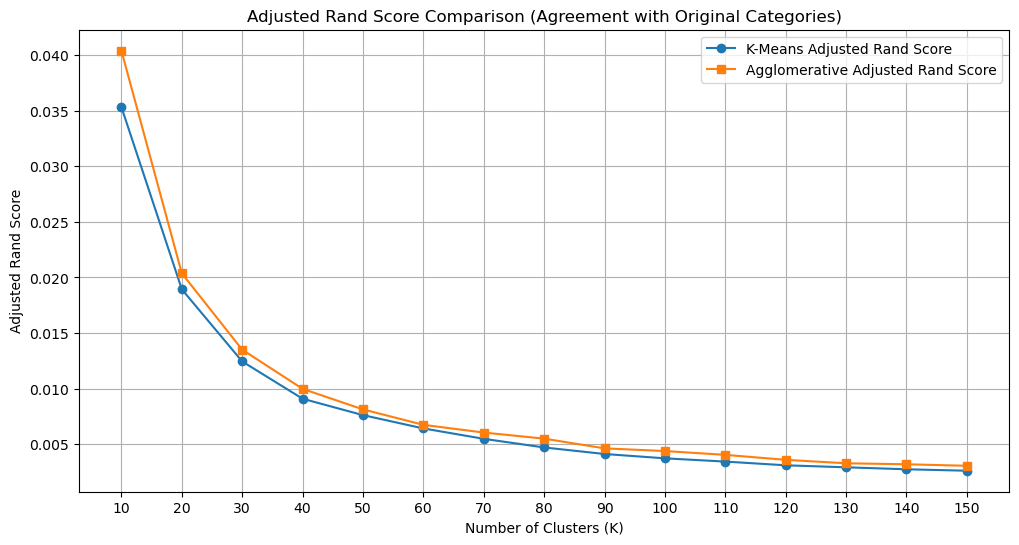

In [6]:
# Plot Adjusted Rand Score
plt.figure(figsize=(12, 6))
plt.plot(results_df['k'], results_df['kmeans_adj_rand'], 'o-', label='K-Means Adjusted Rand Score')
plt.plot(results_df['k'], results_df['agglo_adj_rand'], 's-', label='Agglomerative Adjusted Rand Score')
plt.title('Adjusted Rand Score Comparison (Agreement with Original Categories)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Adjusted Rand Score')
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# --- 5. Final Analysis with the Optimal Algorithm and K ---

OPTIMAL_K = 70 # As determined by our analysis
print(f"--- Final Cluster Analysis with K-Means at K={OPTIMAL_K} ---")

kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto')
df['cluster_final'] = kmeans_final.fit_predict(all_embeddings)

# --- Inspect a few interesting clusters ---
# We will look at the 5 largest clusters to see the most common micro-topics

# Get the sizes of all clusters and find the top 5 largest
top_5_clusters = df['cluster_final'].value_counts().head(5).index.tolist()

print(f"\nAnalyzing the 5 largest micro-topic clusters out of {OPTIMAL_K}:")

for i in top_5_clusters:
    cluster_df = df[df['cluster_final'] == i]
    print(f"\n--- Cluster {i} (Size: {len(cluster_df)}) ---")
    print("\nTop 5 Ticket Subjects in this Cluster:")
    print(cluster_df['Ticket Subject'].value_counts().head(5))

--- Final Cluster Analysis with K-Means at K=70 ---

Analyzing the 5 largest micro-topic clusters out of 70:

--- Cluster 5 (Size: 276) ---

Top 5 Ticket Subjects in this Cluster:
Ticket Subject
Delivery problem         27
Product setup            25
Product compatibility    25
Data loss                22
Refund request           19
Name: count, dtype: int64

--- Cluster 9 (Size: 268) ---

Top 5 Ticket Subjects in this Cluster:
Ticket Subject
Payment issue            25
Product compatibility    24
Network problem          22
Installation support     20
Battery life             20
Name: count, dtype: int64

--- Cluster 40 (Size: 266) ---

Top 5 Ticket Subjects in this Cluster:
Ticket Subject
Delivery problem            25
Payment issue               25
Peripheral compatibility    22
Software bug                21
Refund request              21
Name: count, dtype: int64

--- Cluster 33 (Size: 266) ---

Top 5 Ticket Subjects in this Cluster:
Ticket Subject
Installation support     27
Prod

Calculating distances to the 5th nearest neighbor...


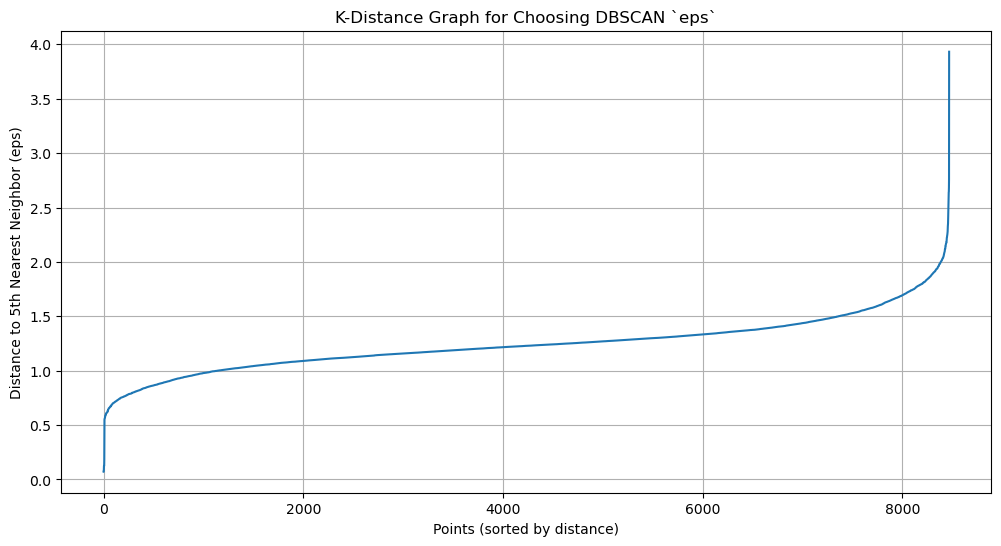

In [8]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# --- 1. Find a suitable `eps` value using the K-distance graph ---

# We need to decide on a `min_samples` value first. A common rule of thumb is 2 * dimensions.
# Since our dimensions are high (768), this is not feasible.
# Let's start with a small, reasonable value like 5.
MIN_SAMPLES = 5

print(f"Calculating distances to the {MIN_SAMPLES}th nearest neighbor...")
# n_neighbors includes the point itself, so we ask for min_samples + 1
neighbors = NearestNeighbors(n_neighbors=MIN_SAMPLES + 1)
neighbors_fit = neighbors.fit(all_embeddings)
distances, indices = neighbors_fit.kneighbors(all_embeddings)

# Get the distance to the k-th neighbor (MIN_SAMPLES in our case)
# We sort these distances to plot them
k_distances = np.sort(distances[:, MIN_SAMPLES], axis=0)

# Plotting the K-distance graph
plt.figure(figsize=(12, 6))
plt.plot(k_distances)
plt.xlabel("Points (sorted by distance)")
plt.ylabel(f"Distance to {MIN_SAMPLES}th Nearest Neighbor (eps)")
plt.title("K-Distance Graph for Choosing DBSCAN `eps`")
plt.grid(True)
plt.show()

In [9]:
# --- 2. Run DBSCAN with the chosen parameters ---

# Parameters chosen from our analysis
EPSILON = 1.5
MIN_SAMPLES = 5

print(f"Running DBSCAN with eps={EPSILON} and min_samples={MIN_SAMPLES}...")
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES, n_jobs=-1) # Use all CPU cores
dbscan_labels = dbscan.fit_predict(all_embeddings)
print("DBSCAN complete.")

# Add the DBSCAN cluster labels to our DataFrame
df['dbscan_cluster'] = dbscan_labels

# --- 3. Analyze the DBSCAN Results ---
n_clusters_found = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_points = np.sum(dbscan_labels == -1)

print("\n--- DBSCAN Analysis Results ---")
print(f"Number of clusters found: {n_clusters_found}")
print(f"Number of noise points (outliers): {n_noise_points} ({n_noise_points / len(df):.2%})")

# Let's analyze the composition of the largest cluster found (excluding noise)
if n_clusters_found > 0:
    # Find the largest cluster (ignoring the noise cluster, which is -1)
    largest_cluster_id = df[df['dbscan_cluster'] != -1]['dbscan_cluster'].value_counts().idxmax()
    largest_cluster_df = df[df['dbscan_cluster'] == largest_cluster_id]

    print(f"\n--- Analysis of Largest Discovered Cluster (ID: {largest_cluster_id}) ---")
    print(f"Size: {len(largest_cluster_df)} tickets")
    
    print("\nCategory Distribution in this cluster:")
    print(largest_cluster_df['Category'].value_counts(normalize=True).apply("{:.2%}".format))
    
    print("\nTop 5 Ticket Subjects in this cluster:")
    print(largest_cluster_df['Ticket Subject'].value_counts().head(5))

# Let's also inspect some of the "noise" tickets to see what makes them unique
print("\n--- Examples of Noise Points (Outliers) ---")
print("These are tickets that did not belong to any dense cluster.")
# Displaying the subject and description of 5 random noise points
print(df[df['dbscan_cluster'] == -1][['Ticket Subject', 'Cleaned_Description']].sample(5, random_state=42))

Running DBSCAN with eps=1.5 and min_samples=5...
DBSCAN complete.

--- DBSCAN Analysis Results ---
Number of clusters found: 18
Number of noise points (outliers): 644 (7.60%)

--- Analysis of Largest Discovered Cluster (ID: 0) ---
Size: 7503 tickets

Category Distribution in this cluster:
Category
Billing            60.11%
Technical Issue    20.66%
General Query      19.23%
Name: proportion, dtype: object

Top 5 Ticket Subjects in this cluster:
Ticket Subject
Software bug             551
Refund request           546
Product compatibility    542
Delivery problem         521
Hardware issue           515
Name: count, dtype: int64

--- Examples of Noise Points (Outliers) ---
These are tickets that did not belong to any dense cluster.
      Ticket Subject                                Cleaned_Description
8284  Account access  issue productpurchased please assist product p...
7895  Account access  issue productpurchased please assist cant see ...
7975  Account access  productpurchased makin

In [10]:
import os
import pandas as pd

# --- Final Step: Generate COMPREHENSIVE Cluster Example Reports (Corrected) ---

# --- 1. Prepare a single, master DataFrame for all reports ---
# We use the main 'df' which already has our text and DBSCAN labels.
# Reload it just in case to ensure we have the original columns.
df_master = pd.read_parquet('processed_customer_support_data.parquet')
df_master['combined_text'] = df_master['Ticket Subject'] + " | " + df_master['Cleaned_Description']

# Add the DBSCAN labels that we already calculated in the previous cell
df_master['dbscan_cluster'] = df['dbscan_cluster'] 

resolved_df = df_master[df_master['Ticket Status'] == 'Closed'].dropna(subset=['Resolution']).copy()
unresolved_df = df_master[df_master['Ticket Status'] != 'Closed'].copy()

# A helper function to sample and format data
def get_samples_for_cluster(cluster_col, cluster_id):
    # Important: We filter the original resolved/unresolved pools now
    resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
    unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
    
    resolved_sample = resolved_in_cluster.sample(1, random_state=42) if not resolved_in_cluster.empty else None
    unresolved_sample = unresolved_in_cluster.sample(1, random_state=42) if not unresolved_in_cluster.empty else None
    
    resolved_problem = resolved_sample['combined_text'].iloc[0] if resolved_sample is not None else "N/A"
    resolution = resolved_sample['Resolution'].iloc[0] if resolved_sample is not None else "N/A"
    unresolved_problem = unresolved_sample['combined_text'].iloc[0] if unresolved_sample is not None else "N/A"
    
    return resolved_problem, resolution, unresolved_problem

# --- 2. Generate Report for K-Means ---
print("--- Generating Comprehensive K-Means Report ---")
kmeans_full_report_data = []
K_range_reports = range(10, 151, 10)

for k in K_range_reports:
    print(f"Processing K-Means for K={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    # Add the new cluster labels to our single master DataFrame
    df_master['current_kmeans_labels'] = kmeans.fit_predict(all_embeddings)
    
    for cluster_id in range(k):
        r_problem, r_solution, u_problem = get_samples_for_cluster('current_kmeans_labels', cluster_id)
        kmeans_full_report_data.append({
            'K_Value': k,
            'Cluster_ID': cluster_id,
            'Example_Resolved_Problem': r_problem,
            'Example_Resolution': r_solution,
            'Example_Unresolved_Problem': u_problem
        })

kmeans_full_report = pd.DataFrame(kmeans_full_report_data)

# --- 3. Generate Report for Agglomerative Clustering ---
print("\n--- Generating Comprehensive Agglomerative Clustering Report ---")
agglo_full_report_data = []

for k in K_range_reports:
    print(f"Processing Agglomerative for K={k}...")
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    df_master['current_agglo_labels'] = agglo.fit_predict(all_embeddings)
    
    for cluster_id in range(k):
        r_problem, r_solution, u_problem = get_samples_for_cluster('current_agglo_labels', cluster_id)
        agglo_full_report_data.append({
            'K_Value': k,
            'Cluster_ID': cluster_id,
            'Example_Resolved_Problem': r_problem,
            'Example_Resolution': r_solution,
            'Example_Unresolved_Problem': u_problem
        })
        
agglo_full_report = pd.DataFrame(agglo_full_report_data)

# --- 4. Generate Report for DBSCAN ---
print("\n--- Generating DBSCAN Report ---")
dbscan_report_data = []
dbscan_cluster_ids = sorted(df_master['dbscan_cluster'].unique())

for cluster_id in dbscan_cluster_ids:
    r_problem, r_solution, u_problem = get_samples_for_cluster('dbscan_cluster', cluster_id)
    dbscan_report_data.append({
        'Cluster_ID': cluster_id,
        'Example_Resolved_Problem': r_problem,
        'Example_Resolution': r_solution,
        'Example_Unresolved_Problem': u_problem
    })

dbscan_full_report = pd.DataFrame(dbscan_report_data)

# --- 5. Save All Reports to CSV ---
output_dir = 'cluster_reports_comprehensive'
os.makedirs(output_dir, exist_ok=True)
print(f"\nComprehensive reports will be saved in the '{output_dir}' directory.")

kmeans_full_report.to_csv(os.path.join(output_dir, 'kmeans_full_report.csv'), index=False)
print("K-Means comprehensive report saved.")

agglo_full_report.to_csv(os.path.join(output_dir, 'agglomerative_full_report.csv'), index=False)
print("Agglomerative comprehensive report saved.")

dbscan_full_report.to_csv(os.path.join(output_dir, 'dbscan_full_report.csv'), index=False)
print("DBSCAN comprehensive report saved.")

print("\n--- All comprehensive reports have been successfully generated. ---")

--- Generating Comprehensive K-Means Report ---
Processing K-Means for K=10...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=20...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=30...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=40...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=50...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=60...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=70...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=80...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=90...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=100...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=110...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=120...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=130...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=140...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing K-Means for K=150...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6


--- Generating Comprehensive Agglomerative Clustering Report ---
Processing Agglomerative for K=10...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=20...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=30...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=40...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=50...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=60...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=70...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=80...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=90...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=100...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=110...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=120...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=130...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=140...


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6

Processing Agglomerative for K=150...

--- Generating DBSCAN Report ---

Comprehensive reports will be saved in the 'cluster_reports_comprehensive' directory.
K-Means comprehensive report saved.
Agglomerative comprehensive report saved.
DBSCAN comprehensive report saved.

--- All comprehensive reports have been successfully generated. ---


/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resolved_in_cluster = resolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_62880/3614427495.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unresolved_in_cluster = unresolved_df[df_master[cluster_col] == cluster_id]
/var/folders/yf/9gf2xg3j2q76vf7cw8s4v4tw0000gn/T/ipykernel_6